# SQuAD Data Exploration

In this notebook we explore the SQuAD training set to give us some insight into the dataset. This will help us for hyperparameter tuning as well as building intuition about how to approach the problem.

In [1]:
"""
Some set up. We assume that the datasets have been downloaded and pre-processed. 
"""
import numpy as np
import matplotlib.pyplot as plt

data_path = "../data/"
train_context_file = data_path + "train.context"
train_question_file = data_path + "train.question"
train_span_file = data_path + "train.span"

## Visualizing Context and Question Lengths

The first piece of information that it will be useful to have is a histogram of the context and question lengths that fall in our dataset. This will guide us in setting these hyperparameters for our model. We'd ideally like to set them as small as possible to improve performance, but we do not want to cut off potentially useful information from our dataset.

For both the contexts and questions, we compute the PDF and CDF for their respective lengths in tokens. 

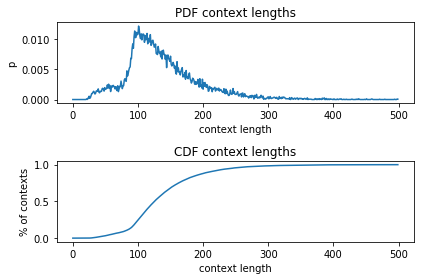

The longest context in the training set was 766 tokens.


In [2]:
"""
Visualize the PDF and CDF for the context lengths.
"""
max_c_len = 800 # safe upper bound on context_len
pdf = np.zeros((max_c_len))
cdf = np.zeros((max_c_len))
num_train, actual_max = 0, 0 
with open(train_context_file) as f:
    for line in f:
        c_len = len(line.split(" "))
        pdf[c_len-1] += 1.0
        num_train += 1
        if c_len > actual_max:
            actual_max = c_len
        
pdf /= num_train # normalize to get probs
cdf[0] = pdf[0]
for i in xrange(1, max_c_len):
    cdf[i] += cdf[i-1] + pdf[i]
    
plotTo = 500 # we don't need to see the super long tail
plt.subplot(211)
plt.title("PDF context lengths")
plt.xlabel("context length")
plt.ylabel("p")
plt.plot(np.arange(plotTo), pdf[:plotTo])  
plt.subplot(212)
plt.title("CDF context lengths")
plt.xlabel("context length")
plt.ylabel("% of contexts")
plt.plot(np.arange(plotTo), cdf[:plotTo])
plt.tight_layout() # don't overlap plots
plt.show()

print "The longest context in the training set was %d tokens." % (actual_max)

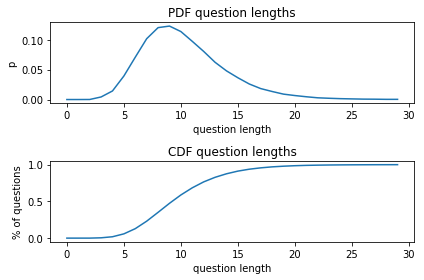

The longest question in the training set was 60 tokens.


In [3]:
"""
Visualize the PDF and CDF for the question lengths.
"""
max_q_len = 60 # safe upper bound on question_len
pdf = np.zeros((max_q_len))
cdf = np.zeros((max_q_len))
num_train, actual_max = 0, 0
with open(train_question_file) as f:
    for line in f:
        q_len = len(line.split(" "))
        pdf[q_len-1] += 1.0
        num_train += 1
        if q_len > actual_max:
            actual_max = q_len
        
pdf /= num_train # normalize to get probs
cdf[0] = pdf[0]
for i in xrange(1, max_q_len):
    cdf[i] += cdf[i-1] + pdf[i]
    
plotTo = 30 # we don't need to see the super long tail
plt.subplot(211)
plt.plot(np.arange(plotTo), pdf[:plotTo]) 
plt.title("PDF question lengths")
plt.xlabel("question length")
plt.ylabel("p") 
plt.subplot(212)
plt.plot(np.arange(plotTo), cdf[:plotTo])
plt.title("CDF question lengths")
plt.xlabel("question length")
plt.ylabel("% of questions")
plt.tight_layout() # don't overlap plots
plt.show()

print "The longest question in the training set was %d tokens." % (actual_max)

## Visualizing the Answer Start and End Positions

The next useful piece of information will be to see in which positions the answer spans most often begin and end. In particular we are interested in when most end, as this may be further illustrative as to how low we can set max_context_len. 

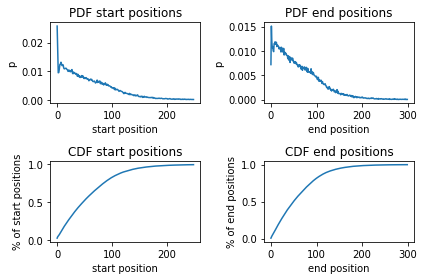

The latest answer start position in the training set at position 605.
The latest answer end position in the training set at position 605.


In [8]:
"""
Visualize the answer start and end for the answer spans.
"""
max_start_pos, max_end_pos = 650, 650 # safe upper bounds
starts, ends = [], []
start_pdf, end_pdf = np.zeros((max_start_pos)), np.zeros((max_start_pos))
start_cdf, end_cdf = np.zeros((max_end_pos)), np.zeros((max_end_pos))
actual_max_start, actual_max_end = 0, 0
num_train = 0
with open(train_span_file) as f:
    for line in f:
        start, end = line.split(" ")
        starts.append(int(start))
        ends.append(int(end))
        start_pdf[int(start)] += 1.0
        end_pdf[int(end)] += 1.0
        num_train += 1
        if int(start) > actual_max_start:
            actual_max_start = int(start)
        if int(end) > actual_max_end:
            actual_max_end = int(end)
    
start_pdf /= num_train # normalize to get probs
end_pdf /= num_train   # normalize to get probs
start_cdf[0] = start_pdf[0]
for i in xrange(1, max_start_pos):
    start_cdf[i] += start_cdf[i-1] + start_pdf[i]
end_cdf[0] = end_pdf[0]
for i in xrange(1, max_end_pos):
    end_cdf[i] += end_cdf[i-1] + end_pdf[i]
    
plotToStart, plotToEnd = 250, 300 # we don't need to see the super long tail
plt.subplot(221)
plt.title("PDF start positions")
plt.xlabel("start position")
plt.ylabel("p") 
plt.plot(np.arange(plotToStart), start_pdf[:plotToStart])
plt.subplot(223)  
plt.title("CDF start positions")
plt.xlabel("start position")
plt.ylabel("% of start positions") 
plt.plot(np.arange(plotToStart), start_cdf[:plotToStart])
plt.subplot(222)
plt.title("PDF end positions")
plt.xlabel("end position")
plt.ylabel("p") 
plt.plot(np.arange(plotToEnd), end_pdf[:plotToEnd])  
plt.subplot(224)  
plt.title("CDF end positions")
plt.xlabel("end position")
plt.ylabel("% of end positions") 
plt.plot(np.arange(plotToEnd), end_cdf[:plotToEnd])
plt.tight_layout() # don't overlap plots
plt.show()

print "The latest answer start position in the training set at position %d." % (actual_max_start)
print "The latest answer end position in the training set at position %d." % (actual_max_end)

## Visualizing the Answer Lengths

The next useful piece of information will be to see the distribution of answer lengths -- that is (end_pos - start_pos). This will be helpful in determining what is the maximum window we should allow our end_pos prediction to be given the predicted start_pos. For example, DrQA sets $i <= j <= 15$ where $i$ is the start_pos and $j$ is the end_pos. 

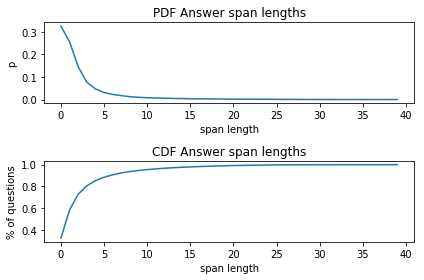

In [21]:
starts, ends = np.array(starts), np.array(ends)
lens = np.subtract(ends, starts)
max_len = np.max(lens)
pdf, cdf = np.zeros((max_len + 1)), np.zeros((max_len + 1))
for length in lens:
    pdf[length] += 1
pdf /= num_train

cdf[0] = pdf[0]
for i in xrange(1, max_len):
    cdf[i] += cdf[i-1] + pdf[i]
    
# plotToStart, plotToEnd = 250, 300 # we don't need to see the super long tail
plotTo = 40
plt.subplot(211)
plt.plot(np.arange(plotTo), pdf[:plotTo])
plt.title("PDF Answer span lengths")
plt.xlabel("span length")
plt.ylabel("p") 
plt.subplot(212)
plt.plot(np.arange(plotTo), cdf[:plotTo])
plt.title("CDF Answer span lengths")
plt.xlabel("span length")
plt.ylabel("% of questions")
plt.tight_layout() # don't overlap plots
plt.show()
    